In [1]:
import torch

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

import numpy as np
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

from TNN import Mining, Model
from TNN.Plot import scatter
from TNN.Loss_Fn import triplet_loss

In [2]:
device = torch.device('cuda:2')
tsne = TSNE(random_state=0)
batch_size_train = 64
batch_size_vis = 256

In [3]:
train_loader = DataLoader(CIFAR10('./CIFAR10/', train=True, download=True,
                                transform=Compose([ToTensor(),Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                               ),batch_size=batch_size_vis, shuffle=True)
test_loader = DataLoader(CIFAR10('./CIFAR10/', train=False, download=True,
                                transform=Compose([ToTensor(),Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                               ),batch_size=batch_size_vis, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
x_test, y_test = next(iter(test_loader))
x_test = x_test.to(device)
y_test = y_test.to(device)

In [5]:
x_train, y_train = next(iter(train_loader))
x_train = x_train.to(device)
y_train = y_train.to(device)

In [6]:
train_loader = DataLoader(CIFAR10('./CIFAR10/', train=True, download=True,
                                transform=Compose([ToTensor(),Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                               ),batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(CIFAR10('./CIFAR10/', train=False, download=True,
                                transform=Compose([ToTensor(),Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                               ),batch_size=batch_size_train, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_tsne_embeds = tsne.fit_transform(x_train.flatten(1).cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(x_test.flatten(1).cpu().detach().numpy())

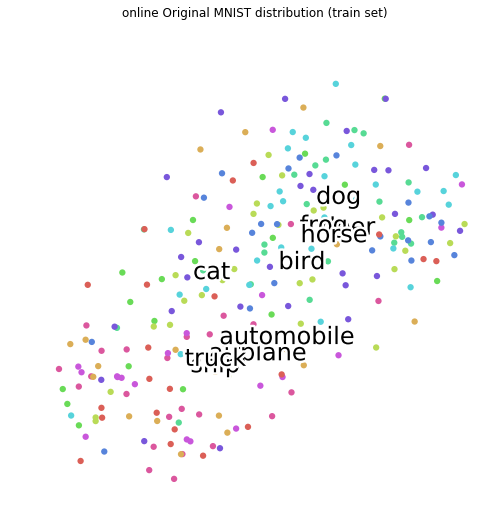

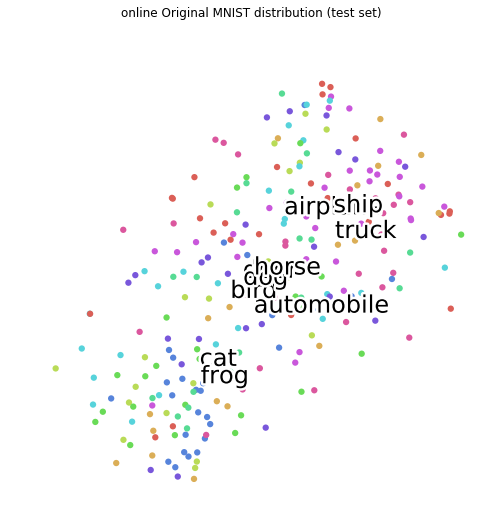

In [8]:
scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'online Original MNIST distribution (train set)', dataset='CIFAR10')
scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'online Original MNIST distribution (test set)', dataset='CIFAR10')

In [9]:
model = Model.TNN_CIFAR10_Drop(input_shape=x_train.shape[1:],output_size=10)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)

In [10]:
model

TNN_CIFAR10_Drop(
  (cnn1a): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (cnn2a): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (cnn3a): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pooling): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (drop2d): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=12544, out_features=10, bias=True)
)

In [11]:
margin = 0.1
for epoch in range(300):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss, pos_triplet, valid_triplet = Mining.online_mine_all(labels, outputs, margin=margin, squared=True, device=device)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%2 == 0:
            print(f"At epoches = {epoch}, i = {i}, loss = {loss:.5f}, trainable_triplet = {pos_triplet}, total_triplets = {valid_triplet}"
                  , end='\r')
    train_epoch_loss = running_loss / len(train_loader)
    # Evaluating on test set
    print(" "*100)
    running_loss = 0.0
    model.eval()
    for i, data in enumerate(test_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss, pos_triplet, valid_triplet = Mining.online_mine_all(labels, outputs, margin=margin, squared=True, device=device)
        running_loss += loss.item()
        if i%2 == 0:
            print(f"Evaluating At epoches = {epoch}, i = {i}, loss = {loss:.5f}", end='\r')
    test_epoch_loss = running_loss / len(test_loader)
    
    print(" "*100)
    print(f"At epoches = {epoch}, epoch_train_loss = {train_epoch_loss:.6f},\tepoch_test_loss = {test_epoch_loss:.6f}")
print('Finished Training')

                                                                                                    
                                                                                                    
At epoches = 0, epoch_train_loss = 0.098246,	epoch_test_loss = 0.086086
                                                                                                    
                                                                                                    
At epoches = 1, epoch_train_loss = 0.098830,	epoch_test_loss = 0.083801
                                                                                                    
                                                                                                    
At epoches = 2, epoch_train_loss = 0.098747,	epoch_test_loss = 0.082501
                                                                                                    
                                                                             

                                                                                                    
                                                                                                    
At epoches = 30, epoch_train_loss = 0.098641,	epoch_test_loss = 0.075793
                                                                                                    
                                                                                                    
At epoches = 31, epoch_train_loss = 0.098556,	epoch_test_loss = 0.075812
                                                                                                    
                                                                                                    
At epoches = 32, epoch_train_loss = 0.098516,	epoch_test_loss = 0.076964
                                                                                                    
                                                                          

                                                                                                    
                                                                                                    
At epoches = 60, epoch_train_loss = 0.098693,	epoch_test_loss = 0.073906
                                                                                                    
                                                                                                    
At epoches = 61, epoch_train_loss = 0.098671,	epoch_test_loss = 0.074287
                                                                                                    
                                                                                                    
At epoches = 62, epoch_train_loss = 0.098463,	epoch_test_loss = 0.074181
                                                                                                    
                                                                          

                                                                                                    
                                                                                                    
At epoches = 90, epoch_train_loss = 0.098582,	epoch_test_loss = 0.073751
                                                                                                    
                                                                                                    
At epoches = 91, epoch_train_loss = 0.098722,	epoch_test_loss = 0.073492
                                                                                                    
                                                                                                    
At epoches = 92, epoch_train_loss = 0.098671,	epoch_test_loss = 0.073295
                                                                                                    
                                                                          

                                                                                                    
                                                                                                    
At epoches = 120, epoch_train_loss = 0.098613,	epoch_test_loss = 0.072225
                                                                                                    
                                                                                                    
At epoches = 121, epoch_train_loss = 0.098739,	epoch_test_loss = 0.073869
                                                                                                    
                                                                                                    
At epoches = 122, epoch_train_loss = 0.098660,	epoch_test_loss = 0.073069
                                                                                                    
                                                                       

                                                                                                    
                                                                                                    
At epoches = 150, epoch_train_loss = 0.098534,	epoch_test_loss = 0.072115
                                                                                                    
                                                                                                    
At epoches = 151, epoch_train_loss = 0.098638,	epoch_test_loss = 0.072836
                                                                                                    
                                                                                                    
At epoches = 152, epoch_train_loss = 0.098619,	epoch_test_loss = 0.072807
                                                                                                    
                                                                       

                                                                                                    
                                                                                                    
At epoches = 180, epoch_train_loss = 0.098631,	epoch_test_loss = 0.072886
                                                                                                    
                                                                                                    
At epoches = 181, epoch_train_loss = 0.098531,	epoch_test_loss = 0.071933
                                                                                                    
                                                                                                    
At epoches = 182, epoch_train_loss = 0.098899,	epoch_test_loss = 0.072547
                                                                                                    
                                                                       

                                                                                                    
                                                                                                    
At epoches = 210, epoch_train_loss = 0.098742,	epoch_test_loss = 0.071955
                                                                                                    
                                                                                                    
At epoches = 211, epoch_train_loss = 0.099037,	epoch_test_loss = 0.071844
                                                                                                    
                                                                                                    
At epoches = 212, epoch_train_loss = 0.098657,	epoch_test_loss = 0.072910
                                                                                                    
                                                                       

                                                                                                    
                                                                                                    
At epoches = 240, epoch_train_loss = 0.098679,	epoch_test_loss = 0.072789
                                                                                                    
                                                                                                    
At epoches = 241, epoch_train_loss = 0.098507,	epoch_test_loss = 0.072738
                                                                                                    
                                                                                                    
At epoches = 242, epoch_train_loss = 0.098654,	epoch_test_loss = 0.072038
                                                                                                    
                                                                       

                                                                                                    
                                                                                                    
At epoches = 270, epoch_train_loss = 0.098795,	epoch_test_loss = 0.072981
                                                                                                    
                                                                                                    
At epoches = 271, epoch_train_loss = 0.098468,	epoch_test_loss = 0.072624
                                                                                                    
                                                                                                    
At epoches = 272, epoch_train_loss = 0.098754,	epoch_test_loss = 0.072691
                                                                                                    
                                                                       

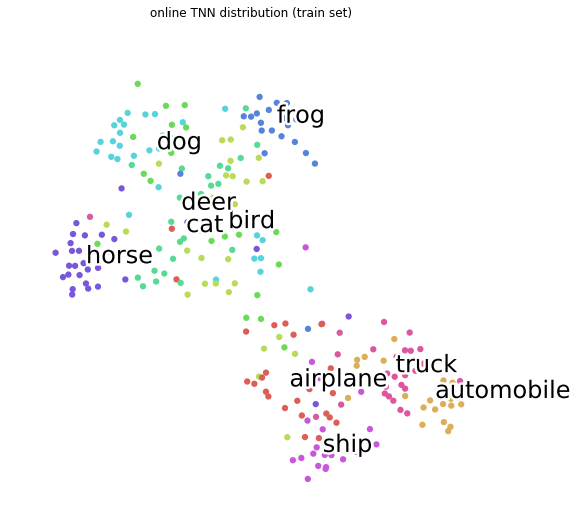

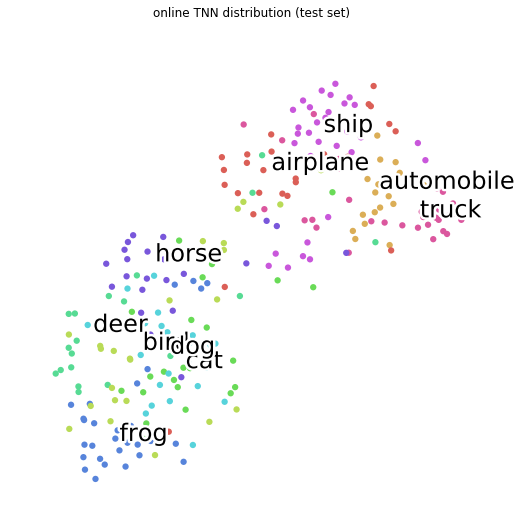

In [12]:
train_outputs = model(x_train)
test_outputs = model(x_test)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'online TNN distribution (train set)', dataset='CIFAR10')
scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'online TNN distribution (test set)', dataset='CIFAR10')